<a href="https://colab.research.google.com/github/evgenymun/wake_word_detection/blob/main/wakeWordDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Wake word detction (Fourth Brain Capston Project)

In this notebook you will find a step by step explanation on how to build a Convolutional Neural Network model that will hopefully detect a specific wake word combination such as 'Hey Fourth Brain' in the audio recording provided by a user. 

High level overview of the content:
1.   The motivation and some background 
2.   Data preparation

    a) Mozile Common Voice and Montreal Forced Alignment

    b) Noise data and Test recording

    c) And more positive data - Google Cloud text to speech :)

3.   Data processing
4.   Modeling and inference 
5.   Testing 
6.   Deploying API
7.   Summary 

## 2. Data preparation

Perhaps Data preparation is one of the difficult parts of this project. I hope the steps outliend here will ease the process. It might or might not go smoothly depending on your environment but at least you will know all the steps. 

We will be using corpus 8.0 https://commonvoice.mozilla.org/en/datasets english version which is around 70GB tar.gz. The best way to process the data is to

1. Free up around 160GB on your **personal machine** 
2. Use any free tool to unzip the data. We used Keka free tool to unzip. It took about 1 hour on MacBook Pro. 
3. Process the data and upload on google drive only the files needed for modeling and testing in Google Colab. 

The data has MP3 files in clips folder and .tsv files with transcriptions of the audio. We will be searching for the wake words in the .tsv files and then moving only the files we need to the GoogleDrive.

## First install a few important packages that will help us work with audio data. 

In [ ]:
#install librosa to help with reading in the audio data
!pip install librosa

In [ ]:
#install soundfile to help with writing out wav files 
!pip install soundfile

In [ ]:
#intall ffmpeg to read mp3 files. I ran this in the terminal. It didn't work from notebook.  
conda install -c conda-forge ffmpeg

Most of the code is coming from https://github.com/shlbatra/TriggerWakeWordDetection/blob/main/train/fetch_dataset_mcv.py to process the data. There were minor changes to the code but in overall it worked pretty well. 

Importing some usefull packages 

In [ ]:
import re
import math

import pandas as pd
import numpy as np

import soundfile
import librosa
import librosa.display

from pathlib import Path
import os 
from os import listdir
from os.path import isfile, join
import shutil

from scipy.io.wavfile import write


### a) Mozile Common Voice and Montreal Forced Alignment

In [ ]:
# Let's select where we saved our original unzipped data and also let's specify wake words and their sequence that we will use later
common_voice_datapath = "/Users/evgenymun/Documents/Documents - Evgeny’s MacBook Pro/FourthBrain/CapstonProject/cv-corpus-8.0-2022-01-19/en"
wake_words = ["hey", "fourth", "brain"]
wake_words_sequence = ["0", "1", "2"]
wake_word_seq_map = dict(zip(wake_words, wake_words_sequence)) #used as lookup table for our labels 

In [ ]:
# Let's specify some folders where we will save processed data
wake_word_datapath = "wake_word_ds"
positive_data = "/positive/audio"
negative_data = "/negative/audio"

In [ ]:
# Sample rate is an important feature of the audio files it's like a resolution of the file 
sr = 16000

In [ ]:
# We will be going thru audio transcripts looking for wake words before we can extract them. Let's create regular expressions 
regex_pattern = r"\b(?:{})\b".format("|".join(map(re.escape, wake_words)))
pattern = re.compile(regex_pattern, flags=re.IGNORECASE)

In [ ]:
# Helper function to scan the text for a specific word
def wake_words_search(pattern, word):
    try:
        return bool(pattern.search(word))
    except TypeError:
        return False

In [ ]:
# As we read the transcripts and searh of the positive and negative files we will be saving audio in wav format and also lab files one by one
def save_wav_lab(path, filename, sentence, decibels=40):
    # load file
    sounddata = librosa.core.load(f"{common_voice_datapath}/clips/{filename}", sr=sr, mono=True)[0]
    # trim
    sounddata = librosa.effects.trim(sounddata, top_db=decibels)[0]
    # save as wav file
    soundfile.write(f"{wake_word_datapath}{path}/{filename.split('.')[0]}.wav", sounddata, sr)
    # write lab file
    with open(f"{wake_word_datapath}{path}/{filename.split('.')[0]}.lab", "w", encoding="utf-8") as f:
        f.write(sentence)

In [ ]:
# change working directory to the root directory where all the data stored
os.chdir(common_voice_datapath)

In [ ]:
# Let's create positive and negative data with training, test and validation sets. To do so we will use .tsv file provided by MCV
train_data = pd.read_csv("train.tsv", sep="\t")
dev_data = pd.read_csv("dev.tsv", sep="\t")
test_data = pd.read_csv("test.tsv", sep="\t")

# For each of the rows in the .tsv data let's see if there is a wake word in there 
positive_train_data = train_data[[wake_words_search(pattern, sentence) for sentence in train_data["sentence"]]]
positive_dev_data = dev_data[[wake_words_search(pattern, sentence) for sentence in dev_data["sentence"]]]
positive_test_data = test_data[[wake_words_search(pattern, sentence) for sentence in test_data["sentence"]]]

# For negative side we need to make sure the wake word is not there 
negative_train_data = train_data[[not wake_words_search(pattern, sentence) for sentence in train_data["sentence"]]]
negative_dev_data = dev_data[[not wake_words_search(pattern, sentence) for sentence in dev_data["sentence"]]]
negative_test_data = test_data[[not wake_words_search(pattern, sentence) for sentence in test_data["sentence"]]]

# Let's see how many records we have in the original data. 
print(f"Total clips available in Train {train_data.shape[0]}")
print(f"Total clips available in Dev {dev_data.shape[0]}")
print(f"Total clips available in Test {test_data.shape[0]}")

# In case of the 'hey fourth brain' we don't have that many files, just a couple of thousands 
print(f"Total clips available in Train with wake words {positive_train_data.shape[0]}")
print(f"Total clips available in Dev with wake words {positive_dev_data.shape[0]}")
print(f"Total clips available in Test with wake words {positive_test_data.shape[0]}")

# Negative data size is huge, a few millions files 
print(f"Total clips available in Train without wake words {negative_train_data.shape[0]}")
print(f"Total clips available in Dev without wake words {negative_dev_data.shape[0]}")
print(f"Total clips available in Test without wake words {negative_test_data.shape[0]}")

In [ ]:
# We don't really need all the negative data for this exercise. Let's trim negative data size to 1%
negative_data_percent = 1
negative_train_data = negative_train_data.sample(
    math.floor(negative_train_data.shape[0] * (negative_data_percent / 100))
)
negative_dev_data = negative_dev_data.sample(math.floor(negative_dev_data.shape[0] * (negative_data_percent / 100)))
negative_test_data = negative_test_data.sample(math.floor(negative_test_data.shape[0] * (negative_data_percent / 100)))

# trimmed negative data sizes
print(f"Total clips available in Train without wake words {negative_train_data.shape[0]}")
print(f"Total clips available in Dev without wake words {negative_dev_data.shape[0]}")
print(f"Total clips available in Test without wake words {negative_test_data.shape[0]}")

In [ ]:
# Now let's create a .csv file for each of the positive and negative datasets. We will have two columns in the .csv file. The path
# will point to the location of the audio file and the sentence will tell us well, the transcript of the audio. 
Path(wake_word_datapath).mkdir(parents=True, exist_ok=True)
# create postiive & negative dataset folder
Path(wake_word_datapath + positive_data).mkdir(parents=True, exist_ok=True)
Path(wake_word_datapath + negative_data).mkdir(parents=True, exist_ok=True)

# save the dataframes we got from above in each dataset
positive_train_data[["path", "sentence"]].to_csv(wake_word_datapath + "/positive/train.csv", index=False)
positive_dev_data[["path", "sentence"]].to_csv(wake_word_datapath + "/positive/dev.csv", index=False)
positive_test_data[["path", "sentence"]].to_csv(wake_word_datapath + "/positive/test.csv", index=False)

negative_train_data[["path", "sentence"]].to_csv(wake_word_datapath + "/negative/train.csv", index=False)
negative_dev_data[["path", "sentence"]].to_csv(wake_word_datapath + "/negative/dev.csv", index=False)
negative_test_data[["path", "sentence"]].to_csv(wake_word_datapath + "/negative/test.csv", index=False)

In [ ]:
# Now let's also save the actual audio data and transcripts into path specified by the previous step. 
# Note that the original version had progress_apply. I'm changing it to apply to avoid errors
positive_train_data.apply(lambda x: save_wav_lab(positive_data, x["path"], x["sentence"]), axis=1)
positive_dev_data.apply(lambda x: save_wav_lab(positive_data, x["path"], x["sentence"]), axis=1)
positive_test_data.apply(lambda x: save_wav_lab(positive_data, x["path"], x["sentence"]), axis=1)

negative_train_data.apply(lambda x: save_wav_lab(negative_data, x["path"], x["sentence"]), axis=1)
negative_dev_data.apply(lambda x: save_wav_lab(negative_data, x["path"], x["sentence"]), axis=1)
negative_test_data.apply(lambda x: save_wav_lab(negative_data, x["path"], x["sentence"]), axis=1)

The next step in data preparation is to create the time stamps for each of the words in the audio file. We will use the timestamps later when we need to extract the positive words from the audio file. To achieve such a fit we will be using Montreal Forced Aligner. It is a shell based tool. All we have to do is to install it first and then run it with a few parameters. This process will produce files of the textGrid format with timestamps.

In [ ]:
# In my case as of (2022) I had to install the kaldi aligner before installing MFA. It took a few hours at night to figure out these steps.
# In your case you might have to experiment. 
!conda create -n aligner kaldi pynini

In [ ]:
# Next activate the environment 
!conda activate aligner

In [ ]:
# As mentioned above I tried installing MFA first. Now let's remove old version 
!pip uninstall montreal-forced-aligner

In [ ]:
# Finally let's run conda installer
!conda install -c conda-forge montreal-forced-aligner

In [ ]:
# MFA needs two parameters. One is the acoustic dictionary 
!mfa model download acoustic english_us_arpa

In [ ]:
# Another is the lexicon dictionary 
!mfa model download dictionary english_us_arpa

In [ ]:
# Test if you got everything correctly 
!mfa model inspect dictionary english_us_arpa

In [ ]:
# Let's change the active directory to positive data
positive_path = '/Users/evgenymun/Documents/Documents - Evgeny’s MacBook Pro/FourthBrain/CapstonProject/cv-corpus-8.0-2022-01-19/en/wake_word_ds/positive'
os.chdir(positive_path)

In [ ]:
# Just checking where we are.
%pwd

In [ ]:
# Finally let the magic begin. Provide where you saved your audio files, then mention to MFA the dictionaries and finally 
# tell where you want the textGrid files to be saved. And you are done! 
!mfa align /Users/evgenymun/mfa/audio english_us_arpa english_us_arpa /Users/evgenymun/mfa/aligned

### b) Noise data and Test recording

OK, we are done with MCV data. Unfortunately there are not enough files with positive words so we will have to create more positive data later on using google cloud services. We can do that in google colab later. For now let's take of the background noise data and the test data where we say the wake word phrase. The rest of the steps will be done in Google Colab. The noise data will hopefully help us achive better results since we want to simulate real life experience in wake word detection. It will be the last step in the data preparation that was performed on personal machine.

In [ ]:
# Let's install sounddevice package to record the audio. Make sure ffmpeg is installed from previous steps. 
!pip install sounddevice

In [ ]:
# Install the package 
import sounddevice as sd

In [ ]:
# Here is a great function that I found somehwere online. I lost the source in the middle of the project. I'll hopefully can add it later. 
# The original function didn't provide dtype=np.int16 option which caused me a lot of pain later on as I worked in colab. The np.int16 makes sure 
# the file can be recognized as wav file. 
def record_background_sound(save_path, n_times=5):
    """
    This function will run automatically `n_times` and record your background sounds so you can make some
    keybaord typing sound and saying something gibberish.
    Note: Keep in mind that you DON'T have to say the wake word this time.
    Parameters
    ----------
    n_times: int, default=50
        The function will run n_times default is set to 50.
    save_path: str
        Where to save the wav file which is generated in every iteration.
        Note: DON'T set it to the same directory where you have saved the wake word or it will overwrite the files.
    """

    input("To start recording your background sounds press Enter: ")
    for i in range(n_times):
        fs = 16000
        seconds = 3
        myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=1, dtype=np.int16)
        sd.wait(1)
        print(f"Recording")
        write(save_path + str(i) + ".wav", fs, myrecording)
        print(f"Currently on {i+1}/{n_times}")

In [ ]:
# Step 1: Record yourself saying the Wake Word. Specify how many time you want to record yourself. I did n_times = 5. 
print("Recording the Background sounds:\n")
record_background_sound("/Users/evgenymun/iCloud Drive (Archive)/Documents/Documents - Evgeny’s MacBook Pro/FourthBrain/CapstonProject/wake_words/positive/", n_times=5)

In [ ]:
# Step 2: Record your background sounds (Just let it run, it will automatically record 200 times)
print("Recording the Background sounds:\n")
record_background_sound("/Users/evgenymun/iCloud Drive (Archive)/Documents/Documents - Evgeny’s MacBook Pro/FourthBrain/CapstonProject/noise_data/", n_times=200)

In [ ]:
# We have all the files in one directory now. Let's split them into train, test and validation. We might not need test or validation but let's 
# create it anyways. 
def list_files(mypath):
  return [mypath + f for f in listdir(mypath) if isfile(join(mypath, f))]

noise_train_complete = list_files('/Users/evgenymun/iCloud Drive (Archive)/Documents/Documents - Evgeny’s MacBook Pro/FourthBrain/CapstonProject/noise_data/')
noise_train = noise_train_complete[:int(len(noise_train_complete) * 0.6)]
noise_test = noise_train_complete[int(len(noise_train_complete) * 0.6):int(len(noise_train_complete) * 0.8)]
noise_dev = noise_train_complete[int(len(noise_train_complete) * 0.8):]

In [ ]:
# Let's confirm the shapes
print(f"Train noise dataset {len(noise_train)}")
print(f"Train noise dataset {len(noise_dev)}")
print(f"Train noise dataset {len(noise_test)}")

In [ ]:
# We will now copy the files from the original folder into three folders test, train and validation. 
path = "/Users/evgenymun/iCloud Drive (Archive)/Documents/Documents - Evgeny’s MacBook Pro/FourthBrain/CapstonProject/"

train = "noise_train"
test = "noise_test"
validation = "noise_validation"

# Copying train noise data 
for f in noise_train:
    file = f.split("/")[-1]

    dst = f"{path}{train}/"+file
    shutil.copy(f,dst)
    print("Copied ", file, "into", train)

# Copying test noise into test directory
for f in noise_test:
    file = f.split("/")[-1]

    dst = f"{path}{test}/"+file
    shutil.copy(f,dst)
    print("Copied ", file, "into", test)

# Copying validation noise into validation directory
for f in noise_dev:
    file = f.split("/")[-1]

    dst = f"{path}{validation}/"+file
    shutil.copy(f,dst)
    print("Copied ", file, "into", validation)

### c) And more positive data - Google Cloud text to speech :)
We are moving on to **Google Colab** platform. So all of the code going foward will be done in Google Colab. To generate more positive data I'll be using google.cloud api text to speech. Follow the istallation instructions here. https://cloud.google.com/text-to-speech/docs/libraries Keep in mind you will need an api key saved somewhere on google drive. As mentioned before data prep was one of the challenging tasks due to many types of data needed in the processing. The data on Google Drive was saved in this directory: 
'/content/gdrive/MyDrive/FourthBrain/CapstoneProject/Data/en/wake_word_ds/'
At this point you can move MCV positive/negative, noise and test data into the google drive. 
Here is the overall structure: 

'./wake_words/ds'

positive/

    words # We don't have the data here yet. It will be done later
        hey
        fourth
        brain 
        test.csv
        train.csv
        dev.csv 
    aligned # Move MFA generated textGrid files here
    audio # Move .wav and .lab files from data prep step
    test.csv # This was also 
    train.csv # generated 
    dev.csv # in the prep step 


noise/ # You can copy all of the bellow from noise prep step

    validation
    test
    train
    noise_train.csv

generated/ # This will be generated in the next step 

    brain 
    fourth 
    hey
    test.csv
    dev.csv
    train.csv
    brain.csv
    hey.csv
    fourth.csv


negative/ # Copy these from data prep step

    audio 
    train.csv
    test.csv
    dev.csv

train.csv # This will be generated in the 

test.csv # next steps.

dev.csv 



In [ ]:
# Let's install all the google cloud text to speech package. In my case I got a few errors at the end 
# but the package still worked as intended. You will need to restart the runtime.
!pip install --upgrade google-cloud-texttospeech

In [ ]:
# Next run this in termainl. It didn't work for me when I ran in here. 
# The credential key should be generated first in the cloud console. 
# See instrctions on the documentation page https://cloud.google.com/text-to-speech/docs/libraries
#export GOOGLE_APPLICATION_CREDENTIALS="/content/gdrive/MyDrive/FourthBrain/CapstoneProject/Data/en/wake_word_ds/gttswakeword-6f3de3955210.json"

In [ ]:
# Let's get some libraries first
import time
from pathlib import Path
import os

import numpy as np
import pandas as pd

from google.cloud import texttospeech
from google.oauth2 import service_account

In [ ]:
# Next we need access to our Google Drive 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Create the root location for all of the data. We will be moving postive and negative data here as well
wake_word_datapath = '/content/gdrive/MyDrive/FourthBrain/CapstoneProject/Data/en/wake_word_ds/'

# Folder for generated google cloud data
generated_data = "generated"

# Let's create a direcotry
Path(f"{wake_word_datapath}/{generated_data}").mkdir(parents=True, exist_ok=True)

# Wake words list 
wake_words = ["hey", "fourth", "brain"]

In [ ]:
# We have to pass the credentials that are stored in .json file generated in the Google Cloud Console (see instructions url from above)
credentials = service_account.Credentials. from_service_account_file('/content/gdrive/MyDrive/FourthBrain/CapstoneProject/Data/en/wake_word_ds/gttswakeword-6f3de3955210.json')

In [ ]:
# Instantiates a client
client = texttospeech.TextToSpeechClient(credentials=credentials)

In [ ]:
# We are ready to rock and roll. We will be adopting a function from here 
# https://github.com/shlbatra/TriggerWakeWordDetection/blob/main/train/generate_dataset_google_tts.py
# Google have some limitations on how many requests can send over certain pariod of time. 
# Due to the limitation on the number of requests will reduce the speaking rate, pitches and voices
# I ran this function several times to ensure I have enough positive data. The data should be balanced if we want to get good results. 
# So I have roughly 60% positive and 40% negative data but that will be clear in the later steps. That's why you will see in the comments that
# ran this several times. 

def generate_voices(word):
    Path(f"{wake_word_datapath}/{generated_data}/{word}").mkdir(parents=True, exist_ok=True)
    # Set the text input to be synthesized
    synthesis_input = texttospeech.SynthesisInput(text=word)
    # Performs the list voices request
    voices = client.list_voices()
    # Get english voices
    en_voices = [voice.name for voice in voices.voices if (voice.name.split("-")[0] == 'en')]
    # speaking_rates = np.arange(0.25, 2.0, 0.25).tolist() #ran this initially, but seems qty is not enough
    speaking_rates = np.arange(0.6, 2.0, 0.15).tolist() #ran this second time np.arange(0.6, 2.0, 0.2)
    pitches = np.arange(-4.0, 5.0, 2).tolist()
    file_count = 0
    start = time.time()

    for voi in en_voices:
        for sp_rate in speaking_rates:
            for pit in pitches:
                file_name = f"{wake_word_datapath}/{generated_data}/{word}/{voi}_{sp_rate}_{pit}.wav"
                voice = texttospeech.VoiceSelectionParams(language_code=voi[:5], name=voi)
                # Select the type of audio file you want returned
                audio_config = texttospeech.AudioConfig(
                    # format of the audio byte stream.
                    audio_encoding=texttospeech.AudioEncoding.LINEAR16,
                    # Speaking rate/speed, in the range [0.25, 4.0]. 1.0 is the normal native speed
                    speaking_rate=sp_rate,
                    # Speaking pitch, in the range [-20.0, 20.0]. 20 means increase 20 semitones from
                    # the original pitch. -20 means decrease 20 semitones from the original pitch.
                    pitch=pit,  # [-10, -5, 0, 5, 10]
                )
                response = client.synthesize_speech(
                    request={"input": synthesis_input, "voice": voice, "audio_config": audio_config}
                )
                # The response's audio_content is binary.
                with open(file_name, "wb") as out:
                    out.write(response.audio_content)
                    file_count += 1
                if file_count % 100 == 0:
                    end = time.time()
                    print(f"generated {file_count} files in {end-start} seconds")

In [ ]:
# Generate for each word. Starting with 'hey'
generate_voices('hey') #Now running just hey word to address imbalanced data. ran this twice, first with speaking rate np.arange(0.25, 2.0, 0.25)

In [ ]:
# Now 'fourth'
generate_voices('fourth')

In [ ]:
# And finaly 'brain'
generate_voices('brain')

Conratulation! You are done with data preparation step. Next we will move on to the data processing step where we will first start with extracting the wake words from the positive data and then aggregating all of the positive and negative data, as well as noise and generated data.

## 3. Data processing

We will now create a timestamp for positive word using textGrid data from MFA step. This work is a sligtly modified version of the great example by https://github.com/shlbatra/TriggerWakeWordDetection/blob/main/train/save_word_alignments.py

In [ ]:
# Installing textgrid package to process the .TextGrid files
!pip install textgrid

In [ ]:
# We will need praat-textgrids 
!pip install praat-textgrids

In [ ]:
# Add the installed package 
import textgrids as tgs
import regex as re

In [ ]:
# Read in positive and negative data
positive_train_data = pd.read_csv(wake_word_datapath+"positive/train.csv")
positive_dev_data = pd.read_csv(wake_word_datapath+"positive/dev.csv")
positive_test_data = pd.read_csv(wake_word_datapath+"positive/test.csv")

negative_train_data = pd.read_csv(wake_word_datapath+"negative/train.csv")
negative_dev_data = pd.read_csv(wake_word_datapath+"negative/dev.csv")
negative_test_data = pd.read_csv(wake_word_datapath+"negative/test.csv")

In [ ]:
# Let's look into what is there. Here you will see the path field with the correct path
# because of the previous runs. The timestamps field is also present here but it was added later 
# in the next step. 
positive_train_data.head()

,path,sentence,timestamps
0,/content/gdrive/MyDrive/FourthBrain/CapstonePr...,Such things in her brain were like so many oat...,"{'such': {'start': 1.25, 'end': 1.6}, 'things'..."
1,/content/gdrive/MyDrive/FourthBrain/CapstonePr...,"Before a life of crime, Doctor Moon was a brai...","{'before': {'start': 0.03, 'end': 0.61}, 'a': ..."
2,/content/gdrive/MyDrive/FourthBrain/CapstonePr...,The series concludes when one team records its...,"{'the': {'start': 0.0, 'end': 0.12}, 'series':..."
3,/content/gdrive/MyDrive/FourthBrain/CapstonePr...,Jacques Villeneuve scored his first Formula On...,"{'jacques': {'start': 0.68, 'end': 1.06}, 'vil..."
4,/content/gdrive/MyDrive/FourthBrain/CapstonePr...,"It is the fourth game in the ""Punch-Out!!","{'it': {'start': 0.6, 'end': 0.76}, 'is': {'st..."


In [ ]:
# Let's look at the shapes. So we only have 1665 postive records
print('positive_train_data: ', positive_train_data.shape)
print('positive_dev_data: ', positive_dev_data.shape)
print('positive_test_data: ', positive_test_data.shape)

print('negative_train_data: ', negative_train_data.shape)
print('negative_dev_data: ', negative_dev_data.shape)
print('negative_test_data: ', negative_test_data.shape)

positive_train_data:  (1665, 3)
positive_dev_data:  (33, 3)
positive_test_data:  (32, 3)
negative_train_data:  (8627, 3)
negative_dev_data:  (162, 3)
negative_test_data:  (162, 3)


In [ ]:
# Let's add a gdrive path to reference the location of the audio wav files
positive_train_data["path"] = positive_train_data["path"].apply(lambda x: wake_word_datapath+"positive/audio/" + x.split(".")[0] + ".wav")
positive_dev_data["path"] = positive_dev_data["path"].apply(lambda x: wake_word_datapath+"positive/audio/" + x.split(".")[0] + ".wav")
positive_test_data["path"] = positive_test_data["path"].apply(lambda x: wake_word_datapath+"positive/audio/" + x.split(".")[0] + ".wav")

negative_train_data["path"] = negative_train_data["path"].apply(lambda x: wake_word_datapath+"negative/audio/" + x.split(".")[0] + ".wav")
negative_dev_data["path"] = negative_dev_data["path"].apply(lambda x: wake_word_datapath+"negative/audio/" + x.split(".")[0] + ".wav")
negative_test_data["path"] = negative_test_data["path"].apply(lambda x: wake_word_datapath+"negative/audio/" + x.split(".")[0] + ".wav")

In [ ]:
# Let's check
positive_train_data.head()

,path,sentence,timestamps
0,/content/gdrive/MyDrive/FourthBrain/CapstonePr...,Such things in her brain were like so many oat...,"{'such': {'start': 1.25, 'end': 1.6}, 'things'..."
1,/content/gdrive/MyDrive/FourthBrain/CapstonePr...,"Before a life of crime, Doctor Moon was a brai...","{'before': {'start': 0.03, 'end': 0.61}, 'a': ..."
2,/content/gdrive/MyDrive/FourthBrain/CapstonePr...,The series concludes when one team records its...,"{'the': {'start': 0.0, 'end': 0.12}, 'series':..."
3,/content/gdrive/MyDrive/FourthBrain/CapstonePr...,Jacques Villeneuve scored his first Formula On...,"{'jacques': {'start': 0.68, 'end': 1.06}, 'vil..."
4,/content/gdrive/MyDrive/FourthBrain/CapstonePr...,"It is the fourth game in the ""Punch-Out!!","{'it': {'start': 0.6, 'end': 0.76}, 'is': {'st..."


In [ ]:
# Function to add timestamp of each word in the positive data. We will be using praat-textgrids. 
def get_timestamps(path):
    filename = path.split("/")[-1].split(".")[0]
    filepath = f"{wake_word_datapath}positive/aligned/{filename}.TextGrid"
    words_timestamps = {}
    if os.path.exists(filepath):
        # print(filepath)
        tg = tgs.TextGrid(filepath) #slightly different format then textGrid package
        for tg_intvl in tg['words']: #textGrids have two parts: word and phones. we are only interested in words this time.
            if len(tg_intvl.text) > 0: #.text field holds the word we need
                words_timestamps[tg_intvl.text] = {"start": tg_intvl.xmin, "end": tg_intvl.xmax} #xmin and xmax have the timestamp
    return words_timestamps

In [ ]:
# Let's add path of the textGrid file with timestamp to the positive data
positive_train_data["timestamps"] = positive_train_data["path"].apply(get_timestamps)
positive_dev_data["timestamps"] = positive_dev_data["path"].apply(get_timestamps)
positive_test_data["timestamps"] = positive_test_data["path"].apply(get_timestamps)

In [ ]:
# Confirm expected output
positive_train_data.head()

,path,sentence,timestamps
0,/content/gdrive/MyDrive/FourthBrain/CapstonePr...,Such things in her brain were like so many oat...,"{'such': {'start': 1.25, 'end': 1.6}, 'things'..."
1,/content/gdrive/MyDrive/FourthBrain/CapstonePr...,"Before a life of crime, Doctor Moon was a brai...","{'before': {'start': 0.03, 'end': 0.61}, 'a': ..."
2,/content/gdrive/MyDrive/FourthBrain/CapstonePr...,The series concludes when one team records its...,"{'the': {'start': 0.0, 'end': 0.12}, 'series':..."
3,/content/gdrive/MyDrive/FourthBrain/CapstonePr...,Jacques Villeneuve scored his first Formula On...,"{'jacques': {'start': 0.68, 'end': 1.06}, 'vil..."
4,/content/gdrive/MyDrive/FourthBrain/CapstonePr...,"It is the fourth game in the ""Punch-Out!!","{'it': {'start': 0.6, 'end': 0.76}, 'is': {'st..."


In [ ]:
# Let's add dummy timestamp to the negative data.  
def get_dummy(path):
    words_timestamps = {}
    words_timestamps['dummy'] = {"start": 0, "end": 0.1} 
    return words_timestamps

negative_train_data["timestamps"] = negative_train_data["path"].apply(get_dummy)
negative_dev_data["timestamps"] = negative_dev_data["path"].apply(get_dummy)
negative_test_data["timestamps"] = negative_test_data["path"].apply(get_dummy)

In [ ]:
# Save updated positive data to .csv file.
positive_train_data.to_csv(wake_word_datapath + "/positive/train.csv", index=False)
positive_dev_data.to_csv(wake_word_datapath + "/positive/dev.csv", index=False)
positive_test_data.to_csv(wake_word_datapath + "/positive/test.csv", index=False)

In [ ]:
# Save updated negative data
negative_train_data.to_csv(wake_word_datapath + "/negative/train.csv", index=False)
negative_dev_data.to_csv(wake_word_datapath + "/negative/dev.csv", index=False)
negative_test_data.to_csv(wake_word_datapath + "/negative/test.csv", index=False)

Now we are ready to extract the key word audio sample from positive data. 

In [ ]:
# Let's define key words mapping that will be used in all of the data processing 
wake_words = ["hey", "fourth", "brain"]
wake_words_sequence = ["0", "1", "2"]
wake_word_seq_map = dict(zip(wake_words, wake_words_sequence))

In [ ]:
# Let's define where the data is again.  
wake_word_datapath = '/content/gdrive/MyDrive/FourthBrain/CapstoneProject/Data/en/wake_word_ds/'
generated_data = 'generated' # will be used later when we add generated data 

In [ ]:
# Before we define the extract function let's load the positive and negative data 
positive_train_data = pd.read_csv(wake_word_datapath + '/positive/train.csv')
positive_dev_data = pd.read_csv(wake_word_datapath + '/positive/dev.csv')
positive_test_data = pd.read_csv(wake_word_datapath + '/positive/test.csv')

negative_train_data = pd.read_csv(wake_word_datapath + '/negative/train.csv')
negative_dev_data = pd.read_csv(wake_word_datapath + '/negative/dev.csv')
negative_test_data = pd.read_csv(wake_word_datapath + '/negative/test.csv')

In [ ]:
# Let's check how many positive data we have
print(f"Positive train shape: {positive_train_data.shape}")
print(f"Positive dev shape: {positive_dev_data.shape}")
print(f"Positive test shape: {positive_test_data.shape}")

Positive train shape: (1665, 3)
Positive dev shape: (33, 3)
Positive test shape: (32, 3)


In [ ]:
# Let's check the negative shape. We will have to reduce the size to address the imbalanced data.  
print(f"Negative train shape: {negative_train_data.shape}")
print(f"Negative dev shape: {negative_dev_data.shape}")
print(f"Negative test shape: {negative_test_data.shape}")

Negative train shape: (8627, 3)
Negative dev shape: (162, 3)
Negative test shape: (162, 3)


In [ ]:
# Let's reduce the number of negative files to balance the data. 
# I'll pick 4000 based on the total available positive data, which includes generated files as well. 
negative_train_data = negative_train_data[:4000]
print(f"Negative train shape: {negative_train_data.shape}")

Negative train shape: (4000, 3)


In [ ]:
# Now we are going to define the extract key word function. 
# All of the processing we are doing is in sample rate of 16000. Later you will see that we will 
# adjust audio sample rate for other files if it's not 16000. 
sr = 16000

In [ ]:
# The following function will extract the key word from positive audio file 
# and save the key word wav file into a new location. It will also add the path to the 
# newly generated audio data to the original dataframe. 

from operator import index
from scipy.sparse import data

key_pattern = re.compile("\'(?P<k>[^ ]+)\'")

def extractWakeWord(audioMeta, dataType):

  dfOut = pd.DataFrame(data={"path": [], "sentence": []})

  for f in audioMeta.to_dict(orient='records'): 
    wavName = f['path'].split("/")[-1]
    audio_data = librosa.core.load(f['path'], sr=sr, mono=True)[0]
    wake_word_found = False
    for word in f['sentence'].lower().split():
      word = re.sub('\W+', '', word)
      if word in wake_words:
        wake_word_found = True

        if word in f['timestamps']:
          timestamps = f['timestamps']
          timestamps = json.loads(key_pattern.sub(r'"\g<k>"', timestamps))

          
          try: 
            word_ts = timestamps[word] # Produced an error for beatles'hey, I had to delete the file
            audio_start_idx = int((word_ts['start'] * 1000) * sr / 1000)
            audio_end_idx = int((word_ts['end'] * 1000) * sr / 1000)
            audio_data = audio_data[audio_start_idx:audio_end_idx]
            Path(f"{wake_word_datapath}positive/words/{word}").mkdir(parents=True, exist_ok=True)
            filePath = f"{wake_word_datapath}positive/words/{word}/{wavName}"
            soundfile.write(filePath, audio_data, sr)
            d = {'path': filePath, 'sentence': word}
            dfOut = dfOut.append(d, ignore_index=True)
          except: 
            print(f"fileName: {wavName}")
          
        break
  dfOut.head()
  dfOut.to_csv(f"{wake_word_datapath}positive/words/{dataType}.csv", index=False)
  print(f"Finished processing positive {dataType}.csv")

In [ ]:
# Let's call the function for each word
extractWakeWord(positive_train_data, 'train')
extractWakeWord(positive_dev_data, 'dev')
extractWakeWord(positive_test_data, 'test')

In [ ]:
# Let's load the updated csv files with path to the exctracted key word
positive_train_data = pd.read_csv(wake_word_datapath + '/positive/words/train.csv')
positive_dev_data = pd.read_csv(wake_word_datapath + '/positive/words/dev.csv')
positive_test_data = pd.read_csv(wake_word_datapath + '/positive/words/test.csv')

In [ ]:
# Let's make sure the size makes sense 
print(f"Positive training dataset size {positive_train_data.shape}")
print(f"Positive validation dataset size {positive_dev_data.shape}")
print(f"Positive test dataset size {positive_test_data.shape}")

Positive training dataset size (1523, 2)
Positive validation dataset size (32, 2)
Positive test dataset size (30, 2)


In [ ]:
# Now we will combine positive and negative data
train_ds = pd.concat([positive_train_data , negative_train_data]).sample(frac=1).reset_index(drop=True)
dev_ds = pd.concat([positive_dev_data , negative_dev_data]).sample(frac=1).reset_index(drop=True)
test_ds = pd.concat([positive_test_data , negative_test_data]).sample(frac=1).reset_index(drop=True)

In [ ]:
# Let's check how many records we have 
print(f"Training dataset size {train_ds.shape}")
print(f"Validation dataset size {dev_ds.shape}")
print(f"Test dataset size {test_ds.shape}")

Training dataset size (5523, 3)
Validation dataset size (194, 3)
Test dataset size (192, 3)


In [ ]:
# Let's check the pattern spread on train_ds. As you can see it's quite imbalanced. 
hey_pattern = re.compile(r'\bhey\b', flags=re.IGNORECASE)
fourth_pattern = re.compile(r'\bfourth\b', flags=re.IGNORECASE)
brain_pattern = re.compile(r'\bbrain\b', flags=re.IGNORECASE)

regex_pattern = r'\b(?:{})\b'.format('|'.join(map(re.escape, wake_words)))
pattern = re.compile(regex_pattern, flags=re.IGNORECASE)
def wake_words_search(pattern, word):
  try:
    return bool(pattern.search(word))
  except TypeError:
    return False
    
print(f"Total hey word {(train_ds[[wake_words_search(hey_pattern, sentence) for sentence in train_ds['sentence']]].size/train_ds.size) * 100} %")
print(f"Total fourth word {(train_ds[[wake_words_search(fourth_pattern, sentence) for sentence in train_ds['sentence']]].size/train_ds.size) * 100} %")
print(f"Total brain word {(train_ds[[wake_words_search(brain_pattern, sentence) for sentence in train_ds['sentence']]].size/train_ds.size) * 100} %")


Total hey word 1.9192467861669382 %
Total fourth word 19.355422777476008 %
Total brain word 6.300923411189571 %


The next step is to add generated data to our positive dataframe

In [ ]:
# Let's load all the generated word data
for word in wake_words:
  d = {}
  d['path'] = [f"{wake_word_datapath}{generated_data}/{word}/{file_name}" for file_name in os.listdir(f"{wake_word_datapath}/{generated_data}/{word}")]
  d['sentence'] = [word] * len(d['path'])
  pd.DataFrame(data=d).to_csv(f"{generated_data}/{word}.csv", index=False)

In [ ]:
# Let's split the generated data into train, test and validation and save correspoinding .csv files
word_cols = {'path' : [], 'sentence': []}
train, dev, test = pd.DataFrame(word_cols), pd.DataFrame(word_cols), pd.DataFrame(word_cols)
for word in wake_words:
  word_df = pd.read_csv(f"{generated_data}/{word}.csv")
  tra, val, te =  np.split(word_df.sample(frac=1, random_state=42),  [int(.6*len(word_df)), int(.8*len(word_df))])
  train = pd.concat([train , tra]).sample(frac=1).reset_index(drop=True)
  dev = pd.concat([dev , val]).sample(frac=1).reset_index(drop=True)
  test = pd.concat([test , te]).sample(frac=1).reset_index(drop=True)

train.to_csv(f"{generated_data}/train.csv", index=False)
dev.to_csv(f"{generated_data}/dev.csv", index=False)
test.to_csv(f"{generated_data}/test.csv", index=False)

In [ ]:
# Let's load the new .csv files with generated words path
train = pd.read_csv(wake_word_datapath + '/generated/train.csv')
dev = pd.read_csv(wake_word_datapath + '/generated/dev.csv')
test = pd.read_csv(wake_word_datapath + '/generated/test.csv')

# Here we are creating empty timestamp field to match with the extracted keyword data 
train['timestamps'] = ''
dev['timestamps'] = ''
test['timestamps'] = ''

In [ ]:
# Let's combine previous data with generated data 
train_ds = pd.concat([train_ds , train]).sample(frac=1).reset_index(drop=True)
dev_ds = pd.concat([dev_ds , dev]).sample(frac=1).reset_index(drop=True)
test_ds = pd.concat([test_ds , test]).sample(frac=1).reset_index(drop=True)

In [ ]:
# Let's see how many records we have. We have around 10.7K records in train data.
print(f"Training dataset size {train_ds.shape}")
print(f"Validation dataset size {dev_ds.shape}")
print(f"Test dataset size {test_ds.shape}")

Training dataset size (10767, 3)
Validation dataset size (1942, 3)
Test dataset size (1940, 3)


In [ ]:
# Now verify how much data we have for each keyword. We have around 20% per keyword. 
print(f"Total hey word {(train_ds[[wake_words_search(hey_pattern, sentence) for sentence in train_ds['sentence']]].size/train_ds.size) * 100} %")
print(f"Total fourth word {(train_ds[[wake_words_search(fourth_pattern, sentence) for sentence in train_ds['sentence']]].size/train_ds.size) * 100} %")
print(f"Total brain word {(train_ds[[wake_words_search(brain_pattern, sentence) for sentence in train_ds['sentence']]].size/train_ds.size) * 100} %")

Total hey word 24.054982817869416 %
Total fourth word 18.900343642611684 %
Total brain word 19.89412092504876 %


In [ ]:
# Let's save the data 
train_ds.to_csv(f"{wake_word_datapath}/train.csv", index=False)
dev_ds.to_csv(f"{wake_word_datapath}/dev.csv", index=False)
test_ds.to_csv(f"{wake_word_datapath}/test.csv", index=False)

The final step in data processing is the nose data. Let's create the csv file with the path to noise data and file names. 

In [ ]:
# Create csv file with noise paths
def list_files(mypath):
  return [mypath + f for f in listdir(mypath) if isfile(join(mypath, f))]

d = {}
d['path'] = [f"{wake_word_datapath}noise/train/{file_name}" for file_name in os.listdir(f"{wake_word_datapath}noise/train")]
pd.DataFrame(data=d).to_csv(f"{wake_word_datapath}noise/noise_train.csv", index=False)

## 4. Modeling and inference

We are now ready to start working on the modeling. We will be using pytorch to build our CNN model. To help with batch training we will need to use dataLoader. The dataloader will help us run the training faster.

Let's install some packages that we will need

In [ ]:
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1).
libportaudiocpp0 is already the newest version (19.6.0-1).
portaudio19-dev is already the newest version (19.6.0-1).
libasound2-dev is already the newest version (1.1.3-5ubuntu0.6).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [ ]:
!pip install pyaudio

In [ ]:
!pip install webrtcvad

In [ ]:
!pip install pydub

In [ ]:
# Import the packages
import os

import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import pyaudio
import pandas as pd
import torchaudio
import wave 
import random
import numpy as np
import librosa

In [ ]:
# Let's connect to google drive just in case. 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Let's define dataset class to help processing individual audio files
# We will be cutting or padding the audio file depending on the size
# We will also be adding the noise data
class WakeWordDataset(Dataset):

    def __init__(self,
                 annotations_file,
                 noise_file,
                 wake_words, 
                 wake_words_sequence, 
                 transformation,
                 target_sample_rate,
                 num_samples,
                 device):
        self.annotations = pd.read_csv(annotations_file)
        self.wake_words = wake_words 
        self.wake_words_sequence = wake_words_sequence 
        self.wake_words_sequence_map = dict(zip(self.wake_words, self.wake_words_sequence)) 
        self.device = device
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        self.noise_file = noise_file

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        slgnal = self._add_noise(signal)
        signal = self.transformation(signal)
        
        return signal, label

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
            audio_data_length = signal.shape[1] / self.target_sample_rate * 1000 #ms
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal.cpu())
        return signal.to(self.device)

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        path = os.path.join(self.annotations.iloc[index, 0])

        return self.annotations.iloc[index, 0] 

    def _get_audio_sample_label(self, index):
        label = len(self.wake_words) # by default negative label
        if self.annotations.iloc[index, 1].lower() in self.wake_words:
            label = int(self.wake_words_sequence_map[self.annotations.iloc[index, 1].lower()])
        return label

    def _add_noise(self, signal):
        if self.noise_file:
            self.noise = pd.read_csv(self.noise_file)
            random_file = random.randint(0,len(self.noise)-1)
            noise_path = self.noise.iloc[random_file][0]

            noise_level =  random.randint(3, 20) # 3 to 20db

            noise_sample, sr = torchaudio.load(f"{noise_path}")
            noise_sample.to(device)

            if random.random() < 0.5:
              noise_sample = noise_sample[:, : signal.shape[1]]
              
            else:
              noise_sample = noise_sample[:, -signal.shape[1]:]
              

            speech_power = signal.norm(p=2)
            noise_power = noise_sample.norm(p=2)

            snr = 10 ** (noise_level / 20)

            scale = snr * noise_power / speech_power

            t = scale * signal

            signal = (scale * signal.to(device) + noise_sample.to(device)) / 2

        return signal

In [ ]:
# Let's test if our dataset class works as expected on the train data
# We should be able to read in and process the train data 
if __name__ == "__main__":
    ANNOTATIONS_FILE = "/content/gdrive/MyDrive/FourthBrain/CapstoneProject/Data/en/wake_word_ds/train.csv"
    NOISE_FILE = "/content/gdrive/MyDrive/FourthBrain/CapstoneProject/Data/en/wake_word_ds/noise/noise_train.csv"
    SAMPLE_RATE = 16000
    NUM_SAMPLES = 16000
    WAKE_WORDS = ["hey", "fourth", "brain"]
    WAKE_WORDS_SEQUENCE = ["0", "1", "2"]


    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using device {device}")

    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=512,
        n_mels=64
        # n_fft=512,
        # hop_length=200,
        # n_mels=40
    )

    # num_mels = 40 # https://en.wikipedia.org/wiki/Mel_scale
    # num_fft = 512 # window length - Fast Fourier Transform
    # hop_length = 200  # making hops of size hop_length each time to sample the next window

    wwd = WakeWordDataset(ANNOTATIONS_FILE,
                          NOISE_FILE,
                          WAKE_WORDS,
                          WAKE_WORDS_SEQUENCE,
                          mel_spectrogram,
                          SAMPLE_RATE,
                          NUM_SAMPLES,
                          device)
    print(f"There are {len(wwd)} samples in the dataset.")
    signal, label = wwd[9] #getting 10th record from our dataset for testing

Using device cuda
There are 10767 samples in the dataset.


In [ ]:
# Now let's define our CNN model. We will be using two convolutional layers, batch normalization
# pooling and ReLu, linear and drop out.  
from torch import nn
from torchsummary import summary
WAKE_WORDS = ["hey", "fourth", "brain"]
class CNN(nn.Module):
    def __init__(self, num_labels, num_maps1, num_maps2, num_hidden_input, hidden_size):
        super(CNN, self).__init__()
        conv0 = nn.Conv2d(1, num_maps1, (8, 16), padding=(4, 0), stride=(2, 2), bias=True)
        pool = nn.MaxPool2d(2)
        conv1 = nn.Conv2d(num_maps1, num_maps2, (5, 5), padding=2, stride=(2, 1), bias=True)
        self.num_hidden_input = num_hidden_input
        self.encoder1 = nn.Sequential(conv0,
                                      nn.ReLU(),
                                      pool,
                                      nn.BatchNorm2d(num_maps1, affine=True))
        self.encoder2 = nn.Sequential(conv1,
                                      nn.ReLU(),
                                      pool,
                                      nn.BatchNorm2d(num_maps2, affine=True))
        self.output = nn.Sequential(nn.Linear(num_hidden_input, hidden_size),
                                    nn.ReLU(),
                                    nn.Dropout(0.1),
                                    nn.Linear(hidden_size, num_labels))

    def forward(self, input_data):
        x1 = self.encoder1(input_data)
        x2 = self.encoder2(x1)
        x = x2.view(-1, self.num_hidden_input)
        return self.output(x)

if __name__ == "__main__":
    num_labels = len(WAKE_WORDS) + 1 
    num_maps1  = 48
    num_maps2  = 128
    num_hidden_input =  1024
    hidden_size = 128

    cnn2 = CNN(num_labels, num_maps1, num_maps2, num_hidden_input, hidden_size)
    summary(cnn2.cuda(), (1, 64, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 48, 33, 9]           6,192
              ReLU-2            [-1, 48, 33, 9]               0
         MaxPool2d-3            [-1, 48, 16, 4]               0
         MaxPool2d-4            [-1, 48, 16, 4]               0
       BatchNorm2d-5            [-1, 48, 16, 4]              96
            Conv2d-6            [-1, 128, 8, 4]         153,728
              ReLU-7            [-1, 128, 8, 4]               0
         MaxPool2d-8            [-1, 128, 4, 2]               0
         MaxPool2d-9            [-1, 128, 4, 2]               0
      BatchNorm2d-10            [-1, 128, 4, 2]             256
           Linear-11                  [-1, 128]         131,200
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   

In [ ]:
# Now let's train our model for 20 epochs. We will use batch size 128 and learning rate 0.001
import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader

BATCH_SIZE = 128
EPOCHS = 20
LEARNING_RATE = 0.001


ANNOTATIONS_FILE = "/content/gdrive/MyDrive/FourthBrain/CapstoneProject/Data/en/wake_word_ds/train.csv"
NOISE_FILE = "/content/gdrive/MyDrive/FourthBrain/CapstoneProject/Data/en/wake_word_ds/noise/noise_train.csv"
SAMPLE_RATE = 16000
NUM_SAMPLES = 16000
WAKE_WORDS = ["hey", "fourth", "brain"]
WAKE_WORDS_SEQUENCE = ["0", "1", "2"]

# This function will help us run batches in parallel 
def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    return train_dataloader

# This function will train single epoch. 
def train_single_epoch(model, data_loader, loss_fn, optimiser, device):
    for input, target in data_loader:
        input, target = input.to(device), target.to(device)

        prediction = model(input)
        loss = loss_fn(prediction, target)

        # backpropagate error and update weights
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    print(f"loss: {loss.item()}")

# Run thru 15 epochs 
def train(model, data_loader, loss_fn, optimiser, device, epochs):
    for i in range(epochs):
        print(f"Epoch {i+1}")
        train_single_epoch(model, data_loader, loss_fn, optimiser, device)
        print("---------------------------")
    print("Finished training")


if __name__ == "__main__":
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using {device}")

   # Transformer helper to convert audio into Mel frequency 
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )
    
    # Instantiating our dataset object and create data loader
    wwd = WakeWordDataset(ANNOTATIONS_FILE,
                          NOISE_FILE,
                          WAKE_WORDS,
                          WAKE_WORDS_SEQUENCE,
                          mel_spectrogram,
                          SAMPLE_RATE,
                          NUM_SAMPLES,
                          device)
    
    train_dataloader = create_data_loader(wwd, BATCH_SIZE)

    # construct model and assign it to device
    num_labels = len(WAKE_WORDS) + 1 # oov
    num_maps1  = 48
    num_maps2  = 128
    num_hidden_input =  1024
    hidden_size = 128

    cnn2 = CNN(num_labels, num_maps1, num_maps2, num_hidden_input, hidden_size).to(device)
    print(cnn2)

    # initialise loss funtion + optimiser
    loss_fn = nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(cnn2.parameters(),
                                 lr=LEARNING_RATE)

    # train model
    train(cnn2, train_dataloader, loss_fn, optimiser, device, EPOCHS)

    # save model
    torch.save(cnn2.state_dict(), "/content/gdrive/MyDrive/FourthBrain/CapstoneProject/wakeworddetaction_cnn7.pth")
    print("Trained feed forward net saved at wakeworddetaction_cnn7.pth")

Using cuda
CNN(
  (encoder1): Sequential(
    (0): Conv2d(1, 48, kernel_size=(8, 16), stride=(2, 2), padding=(4, 0))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(48, 128, kernel_size=(5, 5), stride=(2, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=4, bias=True)
  )
)
Epoch 1
loss: 0.12104733288288116
---------------------------
Epoch 2
loss: 0.008333018980920315
---------------------------
Epoch 3
loss: 0.0039985752664506435
-------------------------

In [ ]:
# Let's test how well our model predicts on test data
import torch
import torchaudio
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

class_mapping = [
    "hey", "fourth", "brain", "negative"
]

ANNOTATIONS_FILE = "/content/gdrive/MyDrive/FourthBrain/CapstoneProject/Data/en/wake_word_ds/test.csv"
NOISE_FILE = "/content/gdrive/MyDrive/FourthBrain/CapstoneProject/Data/en/wake_word_ds/noise/noise_train.csv"
SAMPLE_RATE = 16000
NUM_SAMPLES = 16000
WAKE_WORDS = ["hey", "fourth", "brain"]
WAKE_WORDS_SEQUENCE = ["0", "1", "2"]

actual = []
pred = []

def predict(model, input, target, class_mapping):
    model.eval()
    with torch.no_grad():
        predictions = model(input)
        predicted_index = predictions[0].argmax(0)
        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]

        actual.append(expected)
        pred.append(predicted)

    return predicted, expected


if __name__ == "__main__":
    # load back the model
    num_labels = len(WAKE_WORDS) + 1 # oov
    num_maps1  = 48
    num_maps2  = 128
    num_hidden_input =  1024
    hidden_size = 128

    cnn2 = CNN(num_labels, num_maps1, num_maps2, num_hidden_input, hidden_size)
    state_dict = torch.load("/content/gdrive/MyDrive/FourthBrain/CapstoneProject/wakeworddetaction_cnn7.pth", map_location=torch.device('cpu'))
    cnn2.load_state_dict(state_dict)

    # Transformer
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=512,
        n_mels=64
        # n_fft=512,
        # hop_length=200,
        # n_mels=40
    )

    wwd = WakeWordDataset(ANNOTATIONS_FILE,
                          NOISE_FILE,
                          WAKE_WORDS,
                          WAKE_WORDS_SEQUENCE,
                          mel_spectrogram,
                          SAMPLE_RATE,
                          NUM_SAMPLES,
                          'cpu')


    # Predict the label for each audio file in the test data
    for i in range(len(wwd)): 
        input, target = wwd[i]
        
        input.unsqueeze_(0)

        # make an inference
        predicted, expected = predict(cnn2, input, target,
                                      class_mapping)
    
        print(f"Predicted: '{predicted}', expected: '{expected}'")


Predicted: 'hey', expected: 'hey'
Predicted: 'brain', expected: 'brain'
Predicted: 'brain', expected: 'brain'
Predicted: 'hey', expected: 'hey'
Predicted: 'hey', expected: 'hey'
Predicted: 'brain', expected: 'brain'
Predicted: 'hey', expected: 'hey'
Predicted: 'negative', expected: 'brain'
Predicted: 'brain', expected: 'brain'
Predicted: 'hey', expected: 'hey'
Predicted: 'negative', expected: 'negative'
Predicted: 'hey', expected: 'hey'
Predicted: 'brain', expected: 'brain'
Predicted: 'hey', expected: 'hey'
Predicted: 'fourth', expected: 'fourth'
Predicted: 'hey', expected: 'hey'
Predicted: 'hey', expected: 'hey'
Predicted: 'hey', expected: 'hey'
Predicted: 'hey', expected: 'hey'
Predicted: 'brain', expected: 'brain'
Predicted: 'fourth', expected: 'fourth'
Predicted: 'negative', expected: 'negative'
Predicted: 'hey', expected: 'hey'
Predicted: 'negative', expected: 'negative'
Predicted: 'hey', expected: 'hey'
Predicted: 'hey', expected: 'hey'
Predicted: 'hey', expected: 'hey'
Predicted

In [ ]:
# Let's look at the confucsion matrix.
cm = confusion_matrix(actual, pred, labels=class_mapping)
print(classification_report(actual, pred))

              precision    recall  f1-score   support

       brain       0.99      0.95      0.97       604
      fourth       0.99      0.88      0.93       337
         hey       0.97      0.99      0.98       837
    negative       0.78      0.99      0.87       162

    accuracy                           0.96      1940
   macro avg       0.93      0.95      0.94      1940
weighted avg       0.96      0.96      0.96      1940



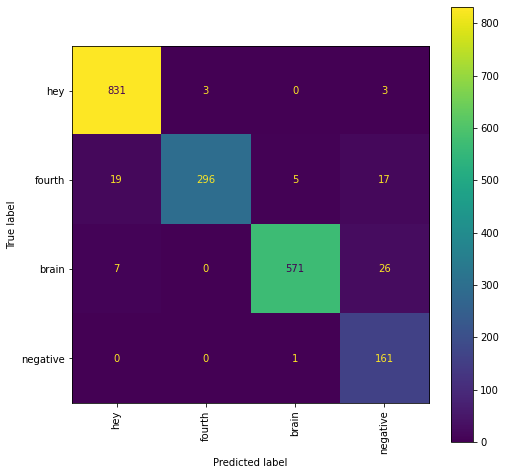

In [ ]:
# Let's plot the confusion matrix 
import matplotlib.pyplot as plt
%matplotlib inline  

cmp = ConfusionMatrixDisplay(cm, display_labels=class_mapping)
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax, xticks_rotation='vertical')

## 5. Testing

We are ready to test a phrase. We will use javascript to record testing phrases. The recording then will be split into words. We will be testing each word and at the same time tracking the sequence. If all wake words found in correct order than wake work is detected. After the process is done you can play individal words and see what our model predicted. Even though we had pretty good accuracy and F1 score during training and testing the actual detection is proved to be far from perfect. One possible reason is the small postive sample.   

In [ ]:
!pip install pydub

In [ ]:
# Yes we  will be needing all of these libraries 
from pydub import AudioSegment
from pydub.silence import split_on_silence
import matplotlib.pyplot as plt
import librosa

import ipywidgets as widgets
from IPython import display as disp
from IPython.display import display, Audio, clear_output
from google.colab import output
import base64
from pydub import AudioSegment
import io
import tempfile
import librosa

import torch
import torchaudio

In [ ]:
# Little helper function to play the audio
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

In [ ]:
# Before we can test the data on the wake word phrase 
# let's create a function to trim or padd the data
def prepare_Stream(signal, num_samples):

    length_signal = signal[0].shape[0]

    if length_signal > num_samples:
        signal = signal[:, :num_samples]

    if length_signal < num_samples:
        num_missing_samples = num_samples - length_signal
        last_dim_padding = (0, num_missing_samples)

        signal = torch.nn.functional.pad(signal, last_dim_padding)

    return signal

In [ ]:
# The function will load the file, split inti words and then make a prediction
# If all three words are detected it will produce a note that wake word is detected
def predict_wake_word(recording_path):
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using {device}")

    WAKE_WORDS = ["hey", "fourth", "brain"]
    num_labels = len(WAKE_WORDS) + 1 # oov
    num_maps1  = 48
    num_maps2  = 128
    num_hidden_input =  1024
    hidden_size = 128

    cnn2 = CNN(num_labels, num_maps1, num_maps2, num_hidden_input, hidden_size)
    state_dict = torch.load("/content/gdrive/MyDrive/FourthBrain/CapstoneProject/wakeworddetaction_cnn6.pth", map_location=torch.device('cpu'))
    cnn2.load_state_dict(state_dict)

    # load urban sound dataset dataset
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=512,
        n_mels=64
        # n_fft=512,
        # hop_length=200,
        # n_mels=40
    )
    mel_spectrogram.to(device)

    cnn2.eval()
    
    classes = WAKE_WORDS[:]
    # negative
    classes.append("negative")

    audio_float_size = 32767

    CHUNK = 500
    CHANNELS = 1
    RATE = SAMPLE_RATE
    RECORD_MILLI_SECONDS = 1000


    testFile = f"/content/gdrive/MyDrive/FourthBrain/CapstoneProject/Data{recording_path}"

    waveform, sample_rate = torchaudio.load(testFile)
    # print(f"Recording SR: {sample_rate}")
    sounddata = librosa.core.load(testFile, sr=RATE, mono=True)[0]
    # print(f"Original audio")
    # play_audio(waveform, sample_rate)


    sound = AudioSegment.from_wav(testFile)
    chunks = split_on_silence(sound, 
        # must be silent for at least half a second
        min_silence_len=100,

        # consider it silent if quieter than -16 dBFS
        silence_thresh=-40
    )

    paths = []
    for i, chunk in enumerate(chunks):
        chunk.export("/content/gdrive/MyDrive/FourthBrain/CapstoneProject/Data/vab/chunk{0}.wav".format(i), format="wav")
        paths.append("/content/gdrive/MyDrive/FourthBrain/CapstoneProject/Data/vab/chunk{0}.wav".format(i))

    inference_track = []
    target_state = 0

    for path in paths: 
    
        waveform = ''
        waveform, sample_rate = torchaudio.load(path)
        # print(f"Word")
        play_audio(waveform, sample_rate)

        signal = prepare_Stream(waveform, 16000)
        with torch.no_grad():
            mel_audio_data = mel_spectrogram(signal.to(device)).float()
            predictions = cnn2(mel_audio_data.unsqueeze_(0).to('cpu'))
            # print(f"predictions: {predictions}")
            predicted_index = predictions[0].argmax(0)
            # print(f"predicted_index: {predicted_index}")
            predicted = classes[predicted_index]
            print(f"predicted: {predicted}")
            print(f"target_state1: {target_state}")
            label = WAKE_WORDS[target_state]
            print(f"label: {label}")

        if predicted == label:
            target_state = target_state + 1 # go to next label
            inference_track.append(predicted)
            print(f"target_state2: {target_state}")
            print(f"inference track: {inference_track}")
            if inference_track == WAKE_WORDS:
                print(f"Wake word {' '.join(inference_track)} detected")
                target_state = 0
                inference_track = []
                break
        elif target_state == 2: 
            target_state = 0

    # plotting the signal in time series
    print("")
    print(f"Original audio shape")
    plt.plot(sounddata)
    plt.title('Signal')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')

In [ ]:
#
# original code: https://github.com/magenta/ddsp/blob/master/ddsp/colab/colab_utils.py
#


# Copyright 2020 The DDSP Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

def record_audio(seconds=3,
                 sample_rate=16000,
                 normalize_db=0.1):
    """Record audio from the browser in colab using javascript.
    Based on: https://gist.github.com/korakot/c21c3476c024ad6d56d5f48b0bca92be
    Args:
      seconds: Number of seconds to record.
      sample_rate: Resample recorded audio to this sample rate.
      normalize_db: Normalize the audio to this many decibels. Set to None to skip
        normalization step.
    Returns:
      An array of the recorded audio at sample_rate.
    """
    # Use Javascript to record audio.
    record_js_code = """
      const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
      const b2text = blob => new Promise(resolve => {
        const reader = new FileReader()
        reader.onloadend = e => resolve(e.srcElement.result)
        reader.readAsDataURL(blob)
      })
      var record = time => new Promise(async resolve => {
        stream = await navigator.mediaDevices.getUserMedia({ audio: true })
        recorder = new MediaRecorder(stream)
        chunks = []
        recorder.ondataavailable = e => chunks.push(e.data)
        recorder.start()
        await sleep(time)
        recorder.onstop = async ()=>{
          blob = new Blob(chunks)
          text = await b2text(blob)
          resolve(text)
        }
        recorder.stop()
      })
      """
    print('Starting recording for {} seconds...'.format(seconds))
    display(disp.Javascript(record_js_code))
    audio_string = output.eval_js('record(%d)' % (seconds * 1000.0))
    print('Finished recording!')
    audio_bytes = base64.b64decode(audio_string.split(',')[1])
    return audio_bytes_to_np(audio_bytes,
                             sample_rate=sample_rate,
                             normalize_db=normalize_db)
    
def audio_bytes_to_np(wav_data,
                      sample_rate=16000,
                      normalize_db=None):
    """Convert audio file data (in bytes) into a numpy array.
    Saves to a tempfile and loads with librosa.
    Args:
      wav_data: A byte stream of audio data.
      sample_rate: Resample recorded audio to this sample rate.
      normalize_db: Normalize the audio to this many decibels. Set to None to skip
        normalization step.
    Returns:
      An array of the recorded audio at sample_rate.
    """
    # Parse and normalize the audio.
    audio = AudioSegment.from_file(io.BytesIO(wav_data))
    audio.remove_dc_offset()
    if normalize_db is not None:
        audio.normalize(headroom=normalize_db)
    # Save to tempfile and load with librosa.
    with tempfile.NamedTemporaryFile(suffix='.wav') as temp_wav_file:
        print(f"temp file: {temp_wav_file.name}")
        fname = temp_wav_file.name
        audio.export(fname, format='wav')
        audio.export(f"/content/gdrive/MyDrive/FourthBrain/CapstoneProject/Data{fname}", format='wav')
        audio_np, unused_sr = librosa.load(fname, sr=sample_rate)

        sound = AudioSegment.from_file(f"/content/gdrive/MyDrive/FourthBrain/CapstoneProject/Data{fname}", format='wav', frame_rate=48000)
        sound = sound.set_frame_rate(16000)
        sound.export(f"/content/gdrive/MyDrive/FourthBrain/CapstoneProject/Data{fname}", format='wav')
        
    return audio_np, fname

Starting recording for 4 seconds...


<IPython.core.display.Javascript object>

Finished recording!
temp file: /tmp/tmpewitutqq.wav


Using cuda


predicted: hey
target_state1: 0
label: hey
target_state2: 1
inference track: ['hey']


predicted: fourth
target_state1: 1
label: fourth
target_state2: 2
inference track: ['hey', 'fourth']


predicted: brain
target_state1: 2
label: brain
target_state2: 3
inference track: ['hey', 'fourth', 'brain']
Wake word hey fourth brain detected

Original audio shape


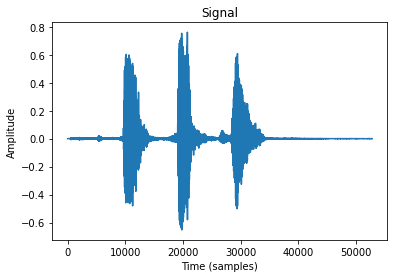

In [ ]:
# You can change the recording time on the right. 
if __name__ == "__main__":
  #@title Record
  #@markdown * Set recording time:

  SAMPLE_RATE = 16000
  record_seconds =   4#@param {type:"number", min:1, max:10, step:1}

  # fname = ''

  def _record_audio(b):
    global audio
    clear_output()
    audio, fname = record_audio(record_seconds, sample_rate=SAMPLE_RATE)
    display(Audio(audio, rate=SAMPLE_RATE))
    
    predict_wake_word(fname)

  button = widgets.Button(description="Start recording...")
  button.on_click(_record_audio)
  display(button)

  

# New Section

# New Section